In [110]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# 1 Anomaly detection

(307, 2)
(307, 2)


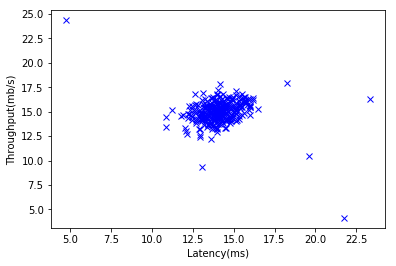

In [111]:
#================== Part 1: Load Example Dataset  ===================
#Visualize the example dataset
dataFile='ex8data1.mat'
data=scio.loadmat(dataFile)
X=data['X']
Xval=data['Xval']
yval=data['yval']
print(X.shape)
print(Xval.shape)
plt.plot(X[:,0],X[:,1],'bx')
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

## 1.1 Gaussdian distribution

## 1.2 Estimating parameters for a Gaussian

In [112]:
#================== Part 2: Estimate the dataset statistics ===================
def estimateGaussian(X):
    '''This function estimates the parameters of a Gaussian distribution using the data in X
    and reuturn the parameters mu and sigma^2'''
    #useful variables
    m,n=X.shape
    
    #compute mu and sigma^2
    mu=np.mean(X,axis=0)
    sigma2=np.mean((X-mu)**2,axis=0)
    Sigma2=(1/m)*np.dot((X-mu).T,(X-mu))#Sigma2是协方差矩阵
    return mu,sigma2,Sigma2

#define the multivariateGaussian function to compute p(x;mu,Sigma)
def multivariateGaussian(x,mu,Sigma2):
    #Ensure that x and mu is column vector
    x=x.reshape(x.shape[0],1)
    mu=mu.reshape(mu.shape[0],1)
    
    #usful variables
    n=x.shape[0]
    
    #compute p(x;mu,Sigma)
    p=(1/((2*np.pi)**(n/2)*np.linalg.det(Sigma2)**0.5))*\
    np.exp(-0.5*np.dot(np.dot((x-mu).T,np.linalg.inv(Sigma2)),x-mu))
    return p

def visualizeFit(X,mu,Sigma2,epsilon=None):
    #plot data
    plt.plot(X[:,0],X[:,1],'bx')
    #plot the contour
    x1_min=np.min(X[:,0])-1
    x1_max=np.max(X[:,1])+1
    x2_min=np.min(X[:,0])-1
    x2_max=np.max(X[:,1])+1
    x1=np.linspace(x1_min,x1_max,50)
    x2=np.linspace(x2_min,x2_max,50)
    Z=np.zeros((x1.shape[0],x2.shape[0]))
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
            this_x=np.array([[x1[i]],[x2[j]]])
            Z[i][j]=multivariateGaussian(this_x,mu,Sigma2)
    x1,x2=np.meshgrid(x1,x2)
    Z=Z.T
    if epsilon==None:
        plt.contour(x1,x2,Z,np.logspace(-20,-2,7))
    else:
        plt.contour(x1,x2,Z,np.array([epsilon]))


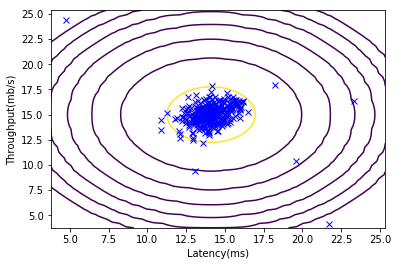

In [116]:
#Estimate mu and sigma2
mu,sigma2,Sigma2=estimateGaussian(X)

Sigma2=np.diag(sigma2)
#题目的matlab代码中使用了这条语句，如果加上这条语句，后面的测试数据时就会跟练习中的数据一样，否则有偏差
#说明在给出的代码里，用的不是多元高斯分布，而是几个一元高斯分布的简单相乘，因为这里协方差矩阵是一个只有
#对角线为非0元素，其他位置都是0,这样就忽略了特征之间的相关性，就根本不是多元高斯分布

#Returns the density of the multivariate normal at each data point(row) of X
m=X.shape[0]
p=np.zeros((m,1))
for i in range(m):
    p[i][0]=float(multivariateGaussian(X[i,:],mu,Sigma2))

#Visualize the fit
visualizeFit(X,mu,Sigma2)
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

## 1.3 Selecting the threshold(epsilon)

In [117]:
#================== Part 3: Find Outliers ===================
def selectThreshold(yval,pval):
    '''This function find the best threshold(epsilon) to use for selecting 
    outliers based on the results from a validation set (pval) and the ground truth (yval).'''
    
    bestEpsilon=0
    bestF1=0
    m=pval.shape[0]
    y_predict=np.zeros(yval.shape)
    
    threshold=np.linspace(np.min(pval),np.max(pval),1000)
    F1=np.zeros((1000,))
    num=0
    for i in range(1000):
        epsilon=threshold[i]        
        for j in range(m):
            if pval[j][0]>=epsilon:y_predict[j][0]=0
            else:y_predict[j][0]=1
        TP=FP=FN=TN=0
        for j in range(m):
            if y_predict[j][0]==1 and yval[j][0]==1:TP+=1
            elif y_predict[j][0]==1 and yval[j][0]==0:FP+=1
            elif y_predict[j][0]==0 and yval[j][0]==1:FN+=1
            elif y_predict[j][0]==0 and yval[j][0]==0:TN+=1
        if TP+FP==0:continue
        else:P=TP/(TP+FP)
        R=TP/(TP+FN)
        num+=1
        F1[i]=2*P*R/(P+R)
    idx=np.argmax(F1)
    bestF1=np.max(F1)
    bestEpsilon=threshold[idx]
    return bestEpsilon,bestF1

In [118]:

pval=np.zeros((m,1))
for i in range(m):
    pval[i][0]=float(multivariateGaussian(Xval[i,:],mu,Sigma2))
epsilon,F1=selectThreshold(yval,pval)
print('Best epsilon found using cross-validation: ',epsilon)
print('Best F1 on Cross Validation Set: ',F1)
print('(you should see a value epsilon of about 8.99e-05)')
print('(you should see a Best F1 value of  0.875000)')

Best epsilon found using cross-validation:  8.9998526319e-05
Best F1 on Cross Validation Set:  0.875
(you should see a value epsilon of about 8.99e-05)
(you should see a Best F1 value of  0.875000)


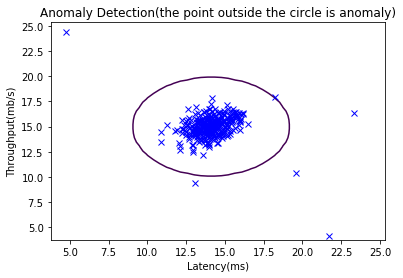

the number of outliers:  6


In [120]:
#Find th outliers in the training set and plot them
visualizeFit(X,mu,Sigma2,epsilon)
plt.title('Anomaly Detection(the point outside the circle is anomaly)')
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

#compute outliers in X
p_unroll=p.ravel()
num=np.sum(p<epsilon)
print('the number of outliers(anomaly): ',num)

## 1.4 High dimensional dataset

In [122]:
#============Part 4:Multidimensional Outliers============
#  We will now use the code from the previous part and apply it to a 
#  harder problem in which more features describe each datapoint and only 
#  some features indicate whether a point is an outlier.

#Loads the dataset
dataFile='ex8data2.mat'
data=scio.loadmat(dataFile)
X=data['X']
Xval=data['Xval']
yval=data['yval']
print(X.shape)
print(Xval.shape)

#Apply the same steps to the larger dataset
mu,sigma2,Sigma2=estimateGaussian(X)
Sigma2=np.diag(sigma2)

#Training set
p=np.zeros((X.shape[0],1))
for i in range(X.shape[0]):
    p[i][0]=multivariateGaussian(X[i,:],mu,Sigma2)

#Cross-validation set
pval=np.zeros((Xval.shape[0],1))
for i in range(Xval.shape[0]):
    pval[i][0]=multivariateGaussian(Xval[i,:],mu,Sigma2)

#Find the best threshold
epsilon,F1=selectThreshold(yval,pval)

print('Best epsilon found using cross-validation: ',epsilon)
print('Best F1 on Cross Validation Set: ',F1)
print('(you should see a value epsilon of about 1.38e-18)')
print('(you should see a Best F1 value of 0.615385)')

#compute the number of anomaly
p_unroll=p.ravel()
num=np.sum(p<epsilon)
print('Outliers found: ',num)

(1000, 11)
(100, 11)
Best epsilon found using cross-validation:  1.3786074982e-18
Best F1 on Cross Validation Set:  0.615384615385
(you should see a value epsilon of about 1.38e-18)
(you should see a Best F1 value of 0.615385)
Outliers found:  117


# 2 Recommender Systems

## 2.1 Movie ratings dataset

In [128]:
#=============== Part 1: Loading movie ratings dataset ================
#Load data
data=scio.loadmat('ex8_movies.mat')
Y=data['Y']
R=data['R']
#Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
#R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
print(Y.shape)

(1682, 943)


In [134]:
def cofiCostFunc(params,Y,R,num_users,num_movies,num_features,lambd):
    '''This function returns the cost and gradient for the collaborative filtering problem'''
    #Unfold the U and W matrices from params
    X,Theta=np.hsplit(params,(num_movies*num_features,))
    X=X.reshape(num_movies,num_features)
    Theta=Theta.reshape(num_users,num_features)
    
    #values need to be returned
    J=0
    X_grad=np.zeros(X.shape)
    Theta_grad=np.zeros(Theta.shape)
    
    #compute
    J=(1/2)*np.sum(R*(np.dot(X,Theta.T)-Y)**2)+(lambd/2)*np.sum(X**2)+(lambd/2)*np.sum(Theta**2)
    X_grad=np.dot((R*np.dot(X,Theta.T)-Y),Theta)+lambd*X
    Theta_grad=np.dot(X.T,(R*np.dot(X,Theta.T)-Y)).T+lambd*Theta
    
    #unroll
    grad=np.hstack((X_grad.ravel(),Theta_grad.ravel()))
    
    return J,grad

In [137]:
#============ Part 2: Collaborative Filtering Cost Function ===========
#  You will now implement the cost function for collaborative filtering.
#  To help you debug your cost function, we have included set of weights
#  that we trained on that. Specifically, you should complete the code in 
#  cofiCostFunc.m to return J.

#Load pre-trained weights(X, Theta, num_users, num_movies, num_features)
data=scio.loadmat('ex8_movieParams.mat')
X=data['X']
Theta=data['Theta']
num_users=data['num_users']
num_movies=data['num_movies']
num_features=data['num_features']

#TEST ON COST FUNCTION
#Reduce the data set size so that this runs faster
num_users,num_movies,num_features=4,5,3
X=X[:num_movies,:num_features]
Theta=Theta[:num_users,:num_features]
Y=Y[:num_movies,:num_users]
R=R[:num_movies,:num_users]

#Evaluate cost function
J,grad=cofiCostFunc(np.hstack((X.ravel(),Theta.ravel())),Y,R,num_users,num_movies,num_features,0)
print('Cost at loaded parameters:(this value should be about 22.22)',J)

Cost at loaded parameters:(this value should be about 22.22) 22.2246037257


In [145]:
#============== Part 3: Collaborative Filtering Gradient ==============
def computeNumericalGradient(theta,Y,R,num_users,num_movies,num_features,lambd):
    '''Computes the gradient using "finite differences and gives 
    us a numerical estimate of the gradient.'''
    numgrad=np.zeros(theta.shape)
    perturb=np.zeros(theta.shape)
    e=10**(-4)
    for i in range(theta.ravel().shape[0]):
        perturb[i]=e
        loss1=cofiCostFunc(theta+perturb,Y,R,num_users,num_movies,num_features,lambd)[0]
        loss2=cofiCostFunc(theta-perturb,Y,R,num_users,num_movies,num_features,lambd)[0]
        numgrad[i]=(loss1-loss2)/(2*e)
        perturb[i]=0
    return numgrad

In [148]:
def checkCostFunction(lambd=0):
    '''%   CHECKCOSTFUNCTION(lambda) Creates a collaborative filering problem 
    to check your cost function and gradients, it will output the 
    analytical gradients produced by your code and the numerical gradients 
    (computed using computeNumericalGradient). These two gradient 
    computations should result in very similar values.'''
    
    #Create small problem
    X_t=np.random.random((4,3))
    Theta_t=np.random.random((5,3))
    
    #Zap out most entries
    Y=np.dot(X_t,Theta_t.T)
    Y[np.random.random(Y.shape)>0.5]=0
    R=np.zeros(Y.shape)
    R[Y!=0]=1
    
    #Run Gradient Checking
    X=np.random.randn(X_t.shape[0],X_t.shape[1])
    Theta=np.random.randn(Theta_t.shape[0],Theta_t.shape[1])
    num_users=Y.shape[1]
    num_movies=Y.shape[0]
    num_features=Theta_t.shape[1]
    
    #compute numerical grad
    params=np.hstack((X.ravel(),Theta.ravel()))
    numgrad=computeNumericalGradient(params,Y,R,num_users,num_movies,num_features,lambd)
    cost,grad=cofiCostFunc(params,Y,R,num_users,num_movies,num_features,lambd)
    print(numgrad)
    print(grad)
    diff=np.linalg.norm(numgrad-grad,ord=2)/np.linalg.norm(numgrad+grad,ord=2)
    print('If your cost function implementation is correct,then the relative difference \
    will be small(less than 1e-9)')
    print('Relative Difference: ',diff)

In [151]:
#check gradients by running checkNNGradients
checkCostFunction()

[-3.99524018 -2.53422633 -0.42939214  0.5982492   0.41300442  0.4148516
  0.18381715 -1.34891826 -1.47837864  0.89446214 -1.81677765 -1.40714047
  0.          0.          0.          0.0201171   0.19437302  0.50723084
 -0.16950688  2.00757809  1.74470031  3.46241062  3.26627035  0.99715203
 -3.09943272  0.12873912  1.7366921 ]
[-3.99524018 -2.53422633 -0.42939214  0.5982492   0.41300442  0.4148516
  0.18381715 -1.34891826 -1.47837864  0.89446214 -1.81677765 -1.40714047
  0.          0.          0.          0.0201171   0.19437302  0.50723084
 -0.16950688  2.00757809  1.74470031  3.46241062  3.26627035  0.99715203
 -3.09943272  0.12873912  1.7366921 ]
If your cost function implementation is correct,then the relative difference     will be small(less than 1e-9)
Relative Difference:  1.55486960809e-12


In [154]:
#========= Part 4: Collaborative Filtering Cost Regularization ========
#  Now, you should implement regularization for the cost function for 
#  collaborative filtering. You can implement it by adding the cost of
#  regularization to the original cost computation.

#Evaluate cost function
params=np.hstack((X.ravel(),Theta.ravel()))
J=cofiCostFunc(params,Y,R,num_users,num_movies,num_features,1.5)[0]
print('Cost at loaded parameters (lambda = 1.5):(this value should be about 31.34)',J)

Cost at loaded parameters (lambda = 1.5):(this value should be about 31.34) 31.3440562443


In [155]:
#======= Part 5: Collaborative Filtering Gradient Regularization ======
#Check gradients by running checkNNGradients
checkCostFunction(1.5)

[  5.1759552   -5.02266303  10.43353374   0.93145176   0.78332145
  -5.62483379   2.8211657   -1.75529844  23.95386446  -0.672239
   2.20221301  -4.98849725  -0.49095     -0.61463474   3.81040267
  -3.80609427   3.32070412  14.54665172  -0.97382823  -1.27556298
  -7.30570293  -1.81070674   1.05117107  -9.57490109  -2.40114685
   4.31236126  22.37928477]
[  5.1759552   -5.02266303  10.43353374   0.93145176   0.78332145
  -5.62483379   2.8211657   -1.75529844  23.95386446  -0.672239
   2.20221301  -4.98849725  -0.49095     -0.61463474   3.81040267
  -3.80609427   3.32070412  14.54665172  -0.97382823  -1.27556298
  -7.30570293  -1.81070674   1.05117107  -9.57490109  -2.40114685
   4.31236126  22.37928477]
If your cost function implementation is correct,then the relative difference     will be small(less than 1e-9)
Relative Difference:  1.96029972088e-12
